In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import tensorflow as tf 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

#Dataset

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("/content/SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [ ]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.xlabel(label)
  plt.ylabel("bike count at noon")
  plt.show()

In [ ]:
df = df.drop(["wind", "visibility", "functional"], axis = 1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


#Train, Validate, Test

In [ ]:
train, validate, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [ ]:
def get_xy(dataframe, y_label, X_label = None):
  df = copy.deepcopy(dataframe)
  if X_label is None :
    X = df.drop([y_label], axis = 1).values.reshape(-1,1)
  elif len(X_label)==1 :
    X= df[X_label[0]].values.reshape(-1,1)
  else:
    X= df[X_label].values

  y = df[y_label].values.reshape(-1,1)
  data = np.hstack((X, y))
  return data, X, y    

# 1_var Linear Regression

In [ ]:
data, X_train_temp, y_train_temp = get_xy(train, "bike_count", ["temp"])
data, X_validate_temp, y_validate_temp = get_xy(validate, "bike_count", ["temp"])
data, X_test_temp, y_test_temp = get_xy(test, "bike_count", ["temp"])

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)
temp_reg.score(X_test_temp, y_test_temp)
print(temp_reg.coef_, temp_reg.intercept_)

[[21.51964446]] [362.7824254]


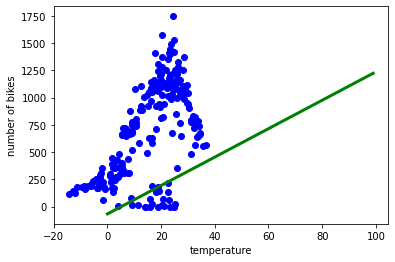

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label="data", color="blue")
x= tf.linspace(-20.0, 40.0, num= 100)
plt.plot(temp_reg.predict(np.array(x).reshape(-1,1)), label="fit", linewidth = 3, color="green")
plt.xlabel("temperature")
plt.ylabel("number of bikes")
plt.show()

#Multiple Linear Regression

In [ ]:
train, validate, test = np.split(df.sample(frac = 1), [int(0.6*len(df)), int(0.8*len(df))])
data, X_train_all, y_train_all = get_xy(train, "bike_count", df.columns[1:])
data, X_validate_all, y_validate_all = get_xy(validate, "bike_count",df.columns[1:])
data, X_test_all, y_test_all = get_xy(test, "bike_count", df.columns[1:])

In [ ]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)
all_reg.score(X_test_all, y_test_all)

0.3093506480063538

#Regression (1_variable) with neural nets

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [ ]:
nn_model_temp = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
nn_model_temp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.1), loss='mean_squared_error', metrics= ['accuracy'])

In [ ]:
history = nn_model_temp.fit(
    X_train_temp.reshape(-1),
    y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data = (X_validate_temp, y_validate_temp))

In [ ]:
def plot_loss(history):

  plt.plot(history.history["loss"], label= "loss")
  plt.plot(history.history["val_loss"], label= "val_loss")
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend=(label)
  plt.grid()
  plt.show()

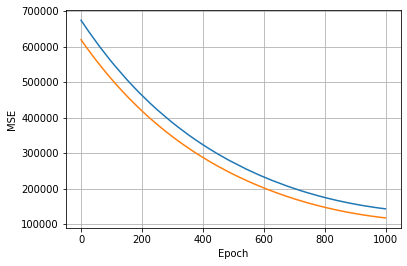

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


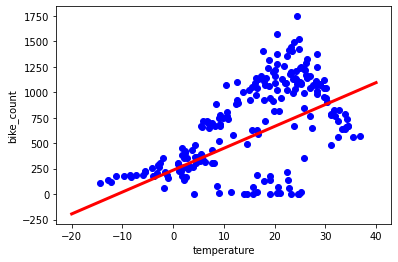

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label= "Data", color="blue")
x=tf.linspace(-20, 40, 100)
plt.plot(x, nn_model_temp.predict(np.array(x).reshape(-1,1)), label="Fit", color= "red", linewidth= 3)
plt.xlabel("temperature")
plt.ylabel("bike_count")
plt.show()

#Regression ( 1_varable ) with multiple layers NN

In [ ]:
temp_nn_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis = None)
temp_nn_normalizer.adapt(X_train_temp)

In [ ]:
nn_model = tf.keras.Sequential([
    temp_nn_normalizer,
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'relu'),
])

In [ ]:
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), loss='mean_squared_error', metrics= ['accuracy'])

In [ ]:
history_2 = nn_model.fit(
    X_train_temp, y_train_temp,
    epochs = 1000,
    verbose = 0,
    batch_size = len(X_train_temp),
    validation_data = (X_validate_temp, y_validate_temp)
)

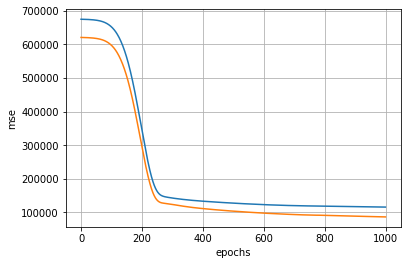

In [ ]:
plot_loss(history_2)

4/4 [==============================] - 0s 3ms/step


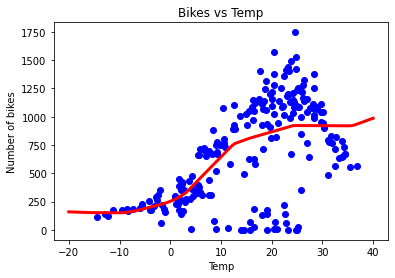

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

#alll_variable Neural_net

In [ ]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis= None)
all_normalizer.adapt(X_train_all)

In [ ]:
all_nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu")
])

In [ ]:
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), loss='mean_squared_error')

In [ ]:
history_allnnmodel = all_nn_model.fit(
    X_train_all, y_train_all,
    verbose=0,
    epochs = 1000,
    batch_size = len(X_train_all),
    validation_data = (X_validate_all, y_validate_all)
)

In [ ]:
def plot_loss(history):
  plt.plot(history.history["loss"], label = "loss")
  plt.plot(history.history["val_loss"], label = "val_loss")
  plt.xlabel("epochs")
  plt.ylabel("mse")
  plt.grid()
  plt.show()

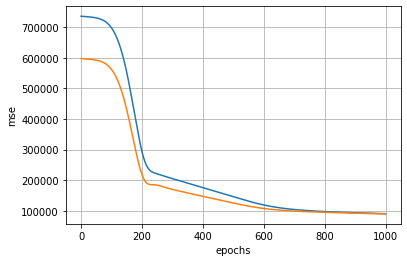

In [ ]:
plot_loss(history_allnnmodel)

#Calculate MSE for both NN and linear regression models (for all the attributes) and compare

In [ ]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = all_nn_model.predict(X_test_all)

3/3 [==============================] - 0s 4ms/step


In [ ]:
def mse(y_pred, y_test):
  return np.square((y_pred - y_test)).mean()

In [ ]:
mse(y_pred_lr, y_test_all)

115040.46592177739

In [ ]:
mse(y_pred_nn, y_test_all)

105323.3141008713

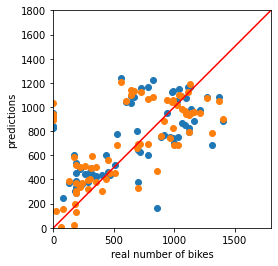

In [ ]:
ax= plt.axes(xlim=(0, 1800), ylim= (0, 1800), aspect='equal')
plt.scatter(y_test_all,y_pred_lr, label ="linear regression")
plt.scatter(y_test_all,y_pred_nn, label ="neural net")
plt.xlabel("real number of bikes")
plt.ylabel("predictions")
lims=[0,1800]
plt.xlim= lims
plt.ylim= lims
_=plt.plot(lims, lims, color="red")
plt.show()